In [ ]:
import os
import sys
import torch
import random 
import numpy as np
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

In [ ]:
### This was a prototype model, but it is no more in use

In [ ]:
sys.path.append(os.path.abspath(os.path.join('..')))
from model.unit3 import DenoisingModelUnit3

In [ ]:
random.seed(42)

In [4]:
def flow_matching(x1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x0 = torch.randn_like(x1)
    target = x1 - x0
    t = torch.rand(x1.size(0), 1)
    t = t.to(device)
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1
    return xt, t, target

In [5]:
## test flow_matching
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x1 = torch.rand(4, 1, 1500).to(device)
xt, t, target = flow_matching(x1)

In [ ]:

def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

BATCH_SIZE = 32

raw_eeg = np.load('./eegdenoisenet/train_input.npy')
clean_eeg = np.load('./eegdenoisenet/train_output.npy')

artifact1 = np.load('./eegdenoisenet/EOG_all_epochs.npy')
artifact2 = np.load('./eegdenoisenet/EMG_all_epochs.npy')

test_input = np.load('./eegdenoisenet/test_input.npy')
test_output = np.load('./eegdenoisenet/test_output.npy')

artifact1 = standardization(artifact1)
artifact2 = standardization(artifact2)
artifact = np.concatenate((artifact1, artifact2), axis=0)

train_input = np.concatenate((raw_eeg, artifact, clean_eeg), axis=0)
train_output = np.concatenate((clean_eeg, artifact, clean_eeg), axis=0)

train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)

train_torch_dataset = Data.TensorDataset(train_input, train_output)

# Split into train and validation sets
val_ratio = 0.15
total_size = len(train_torch_dataset)
val_size = int(total_size * val_ratio)
train_size = total_size - val_size

train_subset, val_subset = random_split(train_torch_dataset, [train_size, val_size])

train_loader = Data.DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = Data.DataLoader(
    dataset=val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

test_torch_dataset = Data.TensorDataset(test_input, test_output)

test_loader = Data.DataLoader(
    dataset=test_torch_dataset,
    batch_size=1,
    shuffle=False,
)

In [7]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps=1e-6

    def forward(self,ground_truth,prediction):
        loss=torch.mean(torch.sqrt(torch.sum(torch.square(ground_truth-prediction), dim=-1))) + self.eps
        return loss

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingModelUnit3(1, 256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = RMSELoss()

os.makedirs('checkpoints/unit3', exist_ok=True)

In [ ]:
writer = SummaryWriter()

num_epochs = 10
print("Starting Training...")
print(f"Training on device: {device}")
torch.autograd.set_detect_anomaly(True)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for step, (train_input, train_output) in enumerate(train_loader):
        clean_eeg = train_output.float().to(device)  
        noisy_eeg = train_input.float().to(device)   
        
        clean_eeg = clean_eeg.unsqueeze(1)
        noisy_eeg = noisy_eeg.unsqueeze(1)

        xt, t, target = flow_matching(clean_eeg)
        
        optimizer.zero_grad()
        pred = model(xt, t, noisy_eeg)
        train_loss = criterion(target, pred)
        train_loss.backward()
        optimizer.step()
        
        running_loss += train_loss.item()

        if step % 50 == 0:
            writer.add_scalar('Loss/train_batch', train_loss.item(), epoch * len(train_loader) + step)
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{step}/{len(train_loader)}], Loss: {train_loss.item():.6f}') #Aug20_15-44-14_Zero
    
    avg_loss = running_loss / len(train_loader)
    writer.add_scalar('Loss/train', avg_loss, epoch)

    # Validation
    print("Validating for epoch:", epoch + 1)
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for step, (val_input, val_output) in enumerate(val_loader):
            clean_eeg = val_output.float().to(device)
            noisy_eeg = val_input.float().to(device)

            clean_eeg = clean_eeg.unsqueeze(1)
            noisy_eeg = noisy_eeg.unsqueeze(1)

            xt, t, target = flow_matching(clean_eeg)
            
            pred = model(xt, t, noisy_eeg)
            loss = criterion(pred, target)
            val_loss += loss.item()
            
            if step % 20 == 0:
                writer.add_scalar('Loss/val_batch', loss.item(), epoch * len(val_loader) + step)
    
    avg_val_loss = val_loss / len(val_loader)
    writer.add_scalar('Loss/val', avg_val_loss, epoch)

    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Learning_Rate', current_lr, epoch)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.2e}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_loss,
            'val_loss': avg_val_loss,
        }
        torch.save(checkpoint, f'checkpoints/unit3/checkpoint_epoch_{epoch+10}.pth')
        print(f"Checkpoint saved for epoch {epoch+10}")

    # Early stopping condition 
    if avg_val_loss < 1e-7:
        print("Validation loss is below threshold, stopping training.")
        break

# Save final model
torch.save(model.state_dict(), 'checkpoints/unit3/final_flow_model_3.pth')
print("Training completed!")

writer.close()

Starting Training...
Training on device: cuda
Epoch [1/10], Batch [0/3427], Loss: 30.133703
Epoch [1/10], Batch [50/3427], Loss: 12.117561
Epoch [1/10], Batch [100/3427], Loss: 9.809468
Epoch [1/10], Batch [150/3427], Loss: 10.109628
Epoch [1/10], Batch [200/3427], Loss: 9.768942
Epoch [1/10], Batch [250/3427], Loss: 10.063304
Epoch [1/10], Batch [300/3427], Loss: 7.654290
Epoch [1/10], Batch [350/3427], Loss: 7.327164
Epoch [1/10], Batch [400/3427], Loss: 9.077210
Epoch [1/10], Batch [450/3427], Loss: 7.536440
Epoch [1/10], Batch [500/3427], Loss: 7.877278
Epoch [1/10], Batch [550/3427], Loss: 7.312387
Epoch [1/10], Batch [600/3427], Loss: 6.390312
Epoch [1/10], Batch [650/3427], Loss: 6.413411
Epoch [1/10], Batch [700/3427], Loss: 7.965856
Epoch [1/10], Batch [750/3427], Loss: 6.647301
Epoch [1/10], Batch [800/3427], Loss: 6.376059
Epoch [1/10], Batch [850/3427], Loss: 5.975611
Epoch [1/10], Batch [900/3427], Loss: 5.244175
Epoch [1/10], Batch [950/3427], Loss: 7.418539
Epoch [1/10],

In [10]:
class FlowSampler:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()
    
    def sample_euler(self, noisy_eeg, num_steps=1000):
        """
        Sample using Euler's method for ODE integration
        Args:
            noisy_eeg: conditioning signal [batch_size, 1, seq_len]
            num_steps: number of integration steps
        Returns:
            clean_eeg: generated clean EEG [batch_size, 1, seq_len]
        """
        # Ensure correct dtype and device
        noisy_eeg = noisy_eeg.to(self.device).float()
        batch_size, channels, seq_len = noisy_eeg.shape
        
        # Start with noise (same dtype as model)
        x = torch.randn_like(noisy_eeg, dtype=torch.float32).to(self.device)
        
        # Time step
        dt = 1.0 / num_steps
        
        with torch.no_grad():
            for i in range(num_steps):
                # Current time
                t = torch.full((batch_size,), i * dt, device=self.device, dtype=torch.float32)
                
                # Predict flow direction
                flow = self.model(x, t, noisy_eeg)
                
                # Euler step: x_{t+1} = x_t + dt * flow
                x = x + dt * flow
        
        return x

In [ ]:
def plot(eeg_data, title):
    # Assuming eeg_data is a 1D numpy array
    sampling_frequency = 256  # Hz
    num_samples = len(eeg_data)
    time_duration = num_samples / sampling_frequency  # seconds
    time = np.linspace(0, time_duration, num_samples, endpoint=False) # Create a time vector

    plt.figure(figsize=(12, 5))
    plt.plot(time, eeg_data)
    plt.title(title)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (arbitrary units, e.g., microvolts)')
    plt.grid(True)
    plt.show()

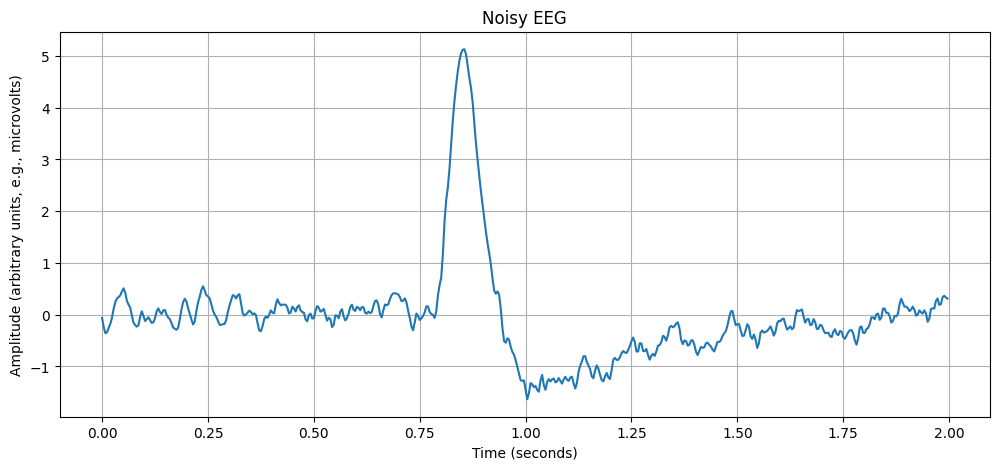

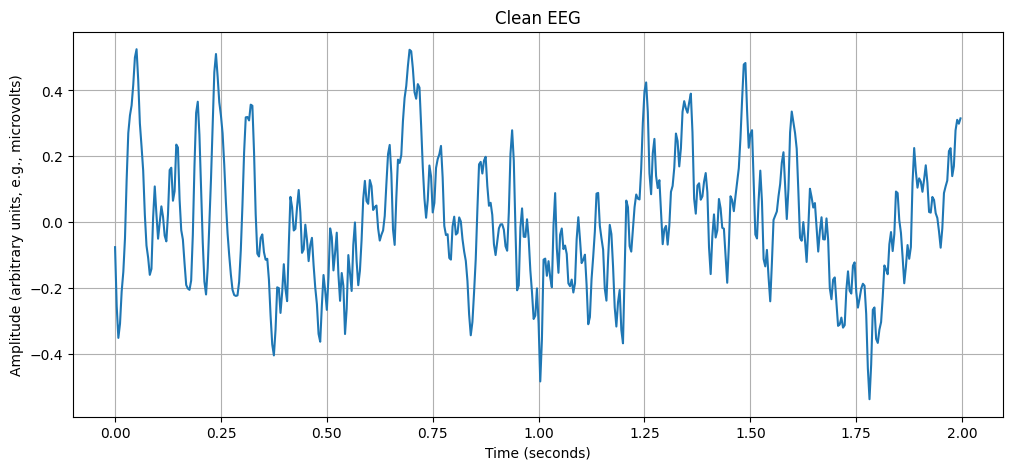

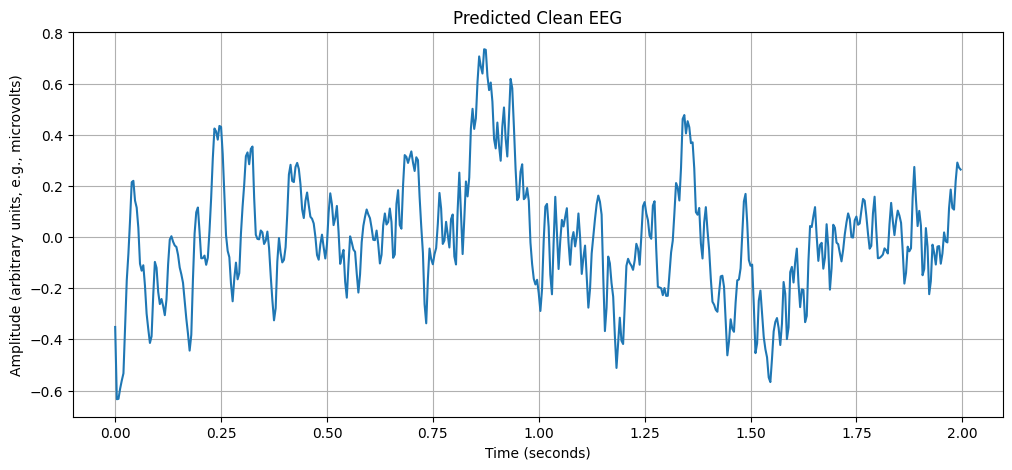

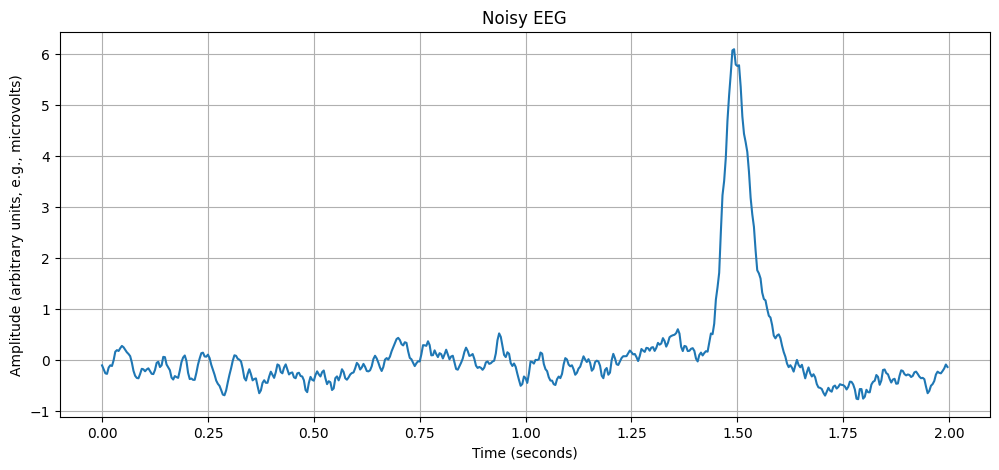

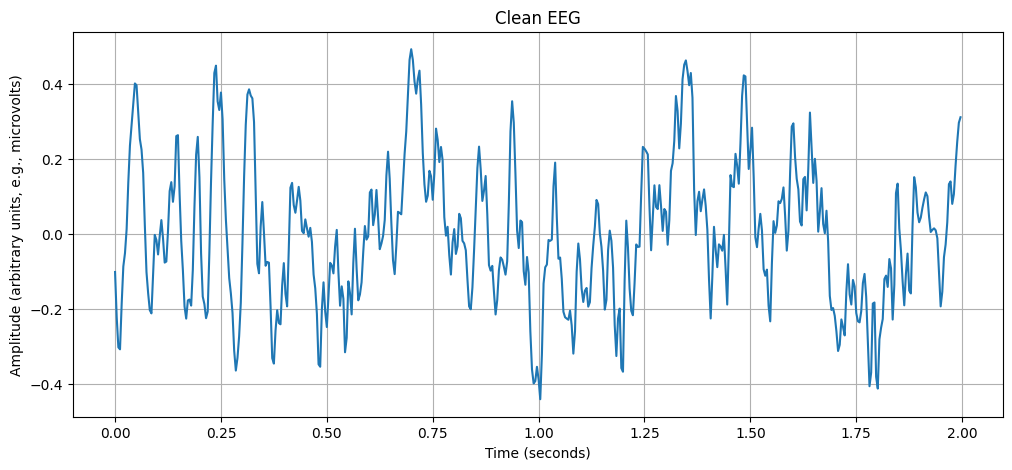

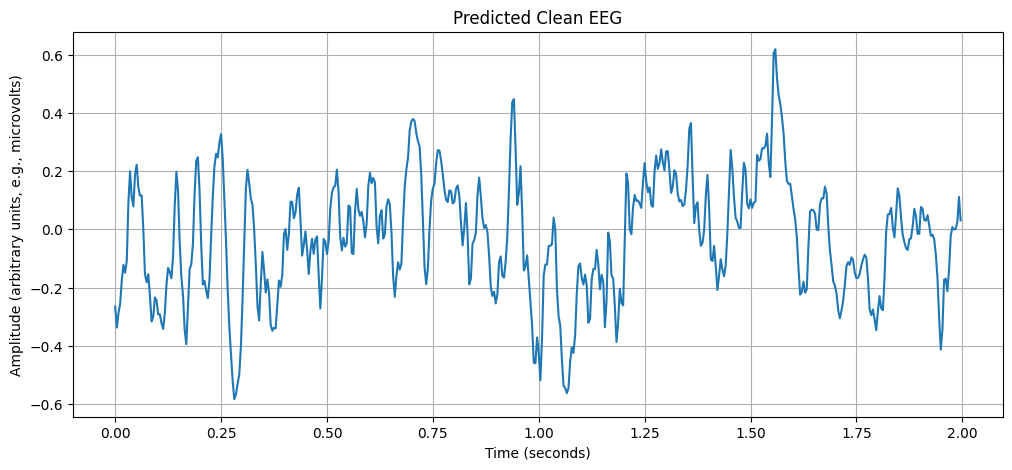

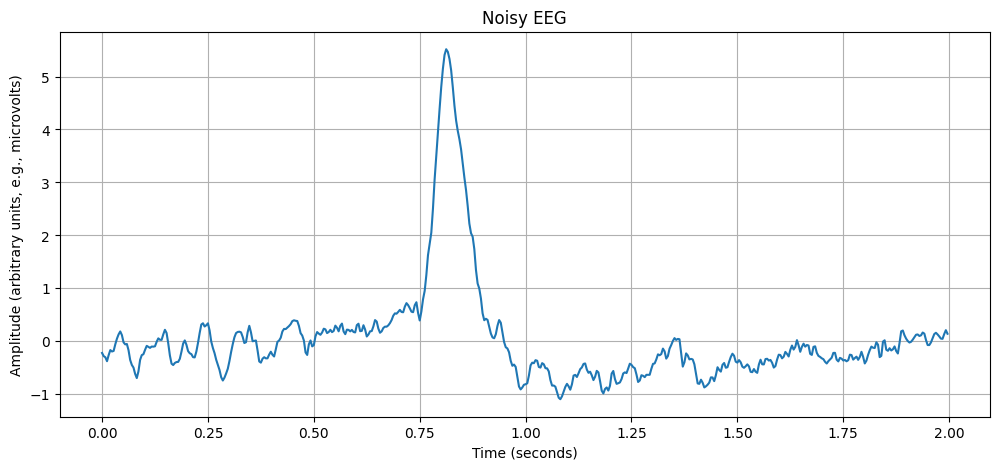

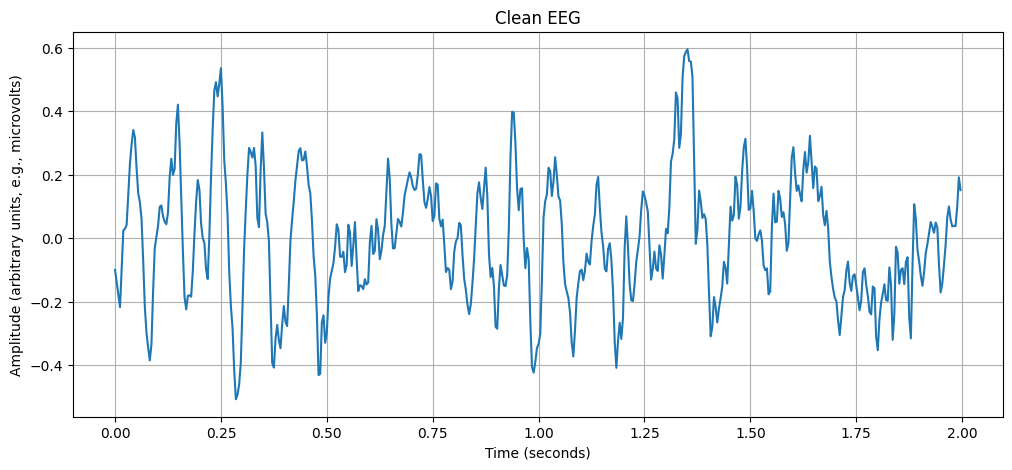

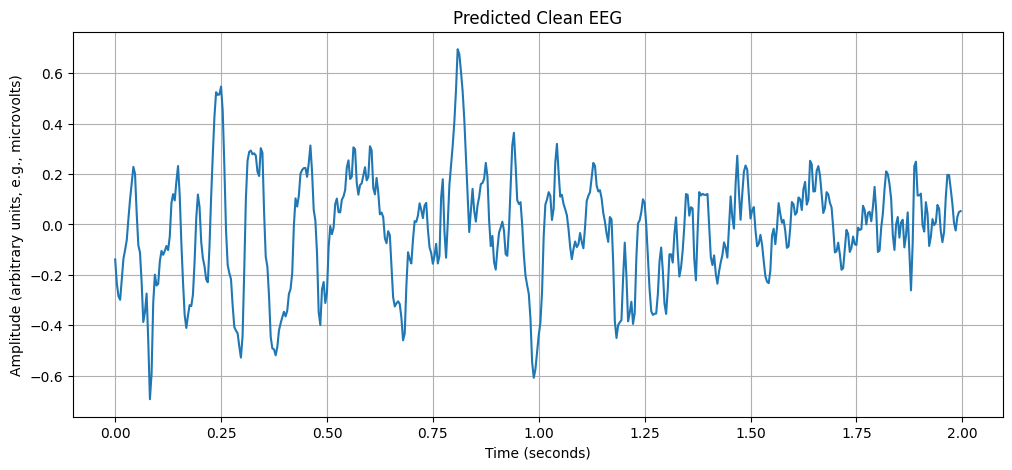

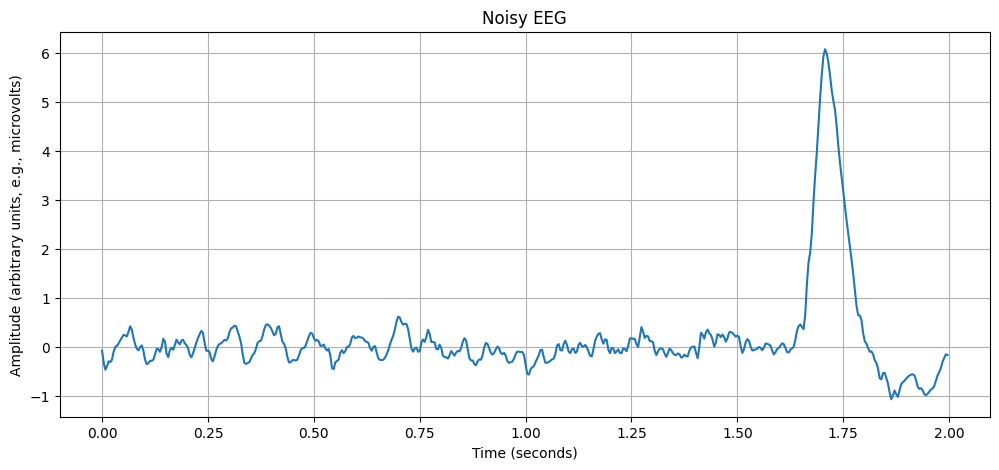

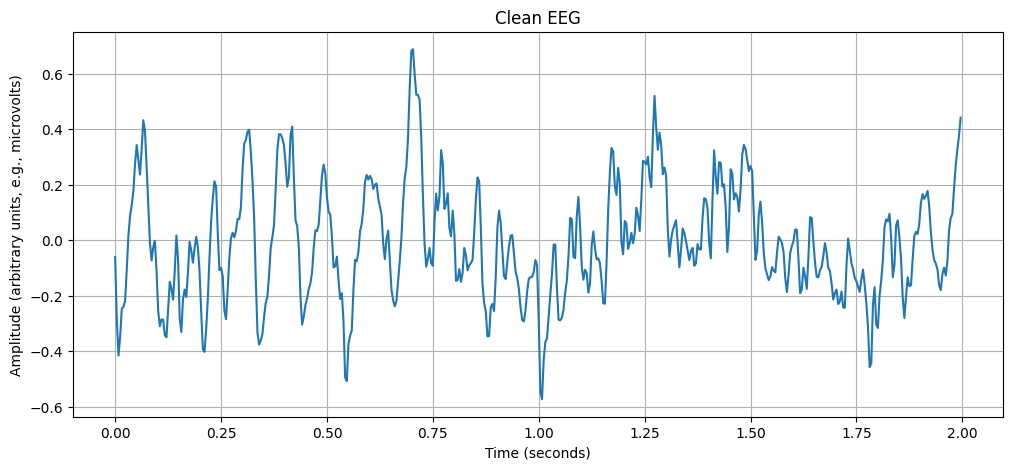

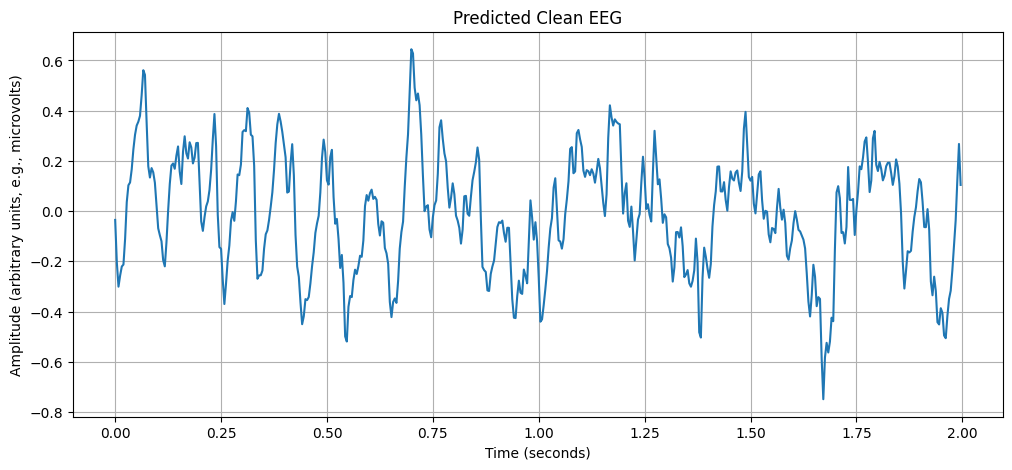

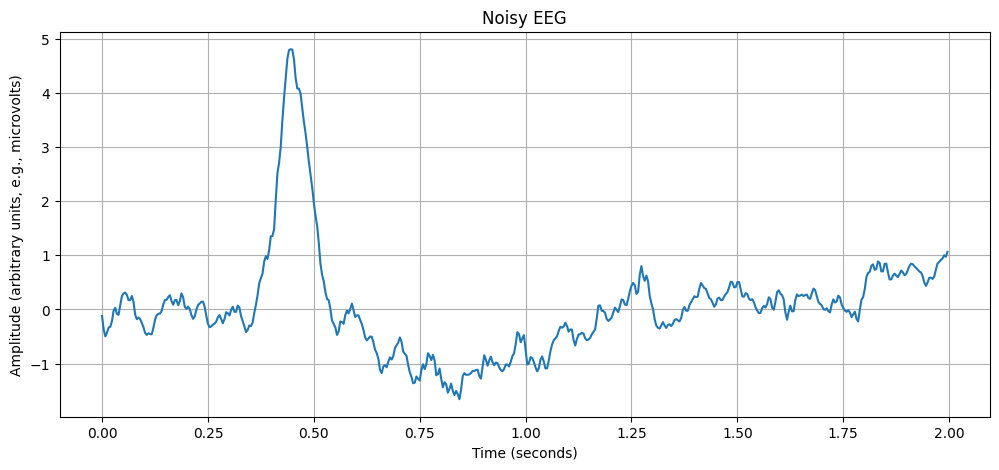

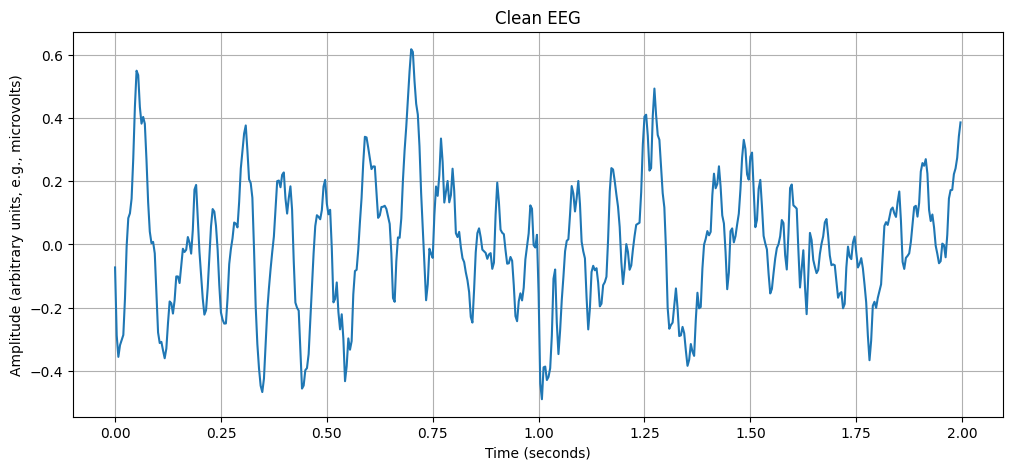

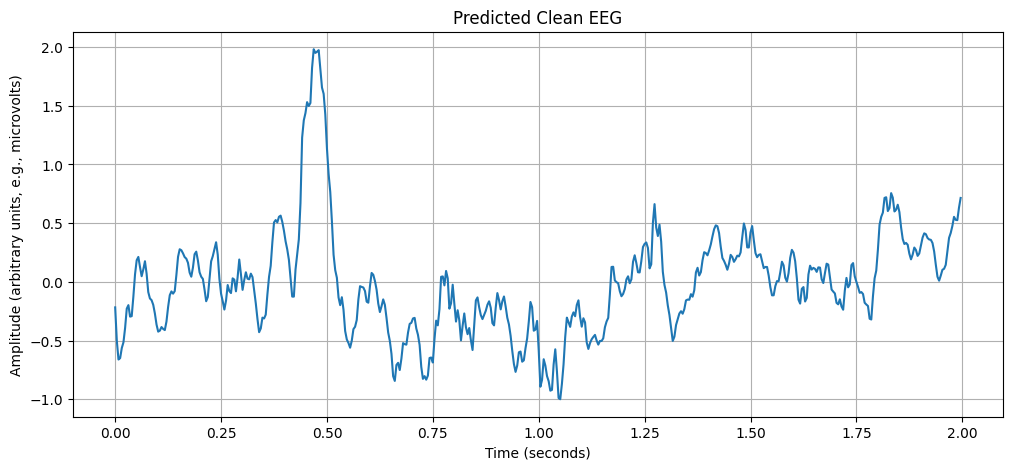

In [12]:
sampler = FlowSampler(model, device)
i = 0
for step, (test_input, test_output) in enumerate(test_loader):
    noisy_eeg = test_input.to(device)
    clean_eeg = test_output.to(device)
    pred_clean_eeg = sampler.sample_euler(noisy_eeg.unsqueeze(1))
    plot(noisy_eeg[0].cpu().numpy(), "Noisy EEG")
    plot(clean_eeg[0].cpu().numpy(), "Clean EEG")
    plot(pred_clean_eeg[0][0].cpu().numpy(), "Predicted Clean EEG")

    i += 1
    if i == 5:
        break